<a href="https://colab.research.google.com/github/DataVoyager220/A-B-test/blob/main/A_B_test_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats import power

In [13]:
# Установка gdown
!pip install gdown

In [4]:
# Скачивание файла с Google Drive
import gdown

file_id = "1nnR4aND9JfFIgdNokxq-y0YyG8ARRp2e"
url = f"https://drive.google.com/uc?id={file_id}"
output = "data.zip"  # Имя скачанного архива
gdown.download(url, output, quiet=False)  # Скачиваем

Downloading...
From: https://drive.google.com/uc?id=1nnR4aND9JfFIgdNokxq-y0YyG8ARRp2e
To: /content/data.zip
100%|██████████| 2.12k/2.12k [00:00<00:00, 4.33MB/s]


'data.zip'

In [5]:
import zipfile
import os

# Распаковываем в папку 'data'
with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

# Проверяем, какие файлы внутри
csv_files = [f for f in os.listdir("data") if f.endswith('.csv')]
print("Найдены CSV-файлы:", csv_files)

Найдены CSV-файлы: ['test_group.csv', 'control_group.csv']


In [24]:
df_control = pd.read_csv("/content/data/control_group.csv", encoding='ISO-8859-1', sep=";")
df_test  = pd.read_csv("/content/data/test_group.csv", encoding='ISO-8859-1', sep=";")

In [25]:
# Добавляем метку группы
df_test['group'] = 'test'
df_control['group'] = 'control'

In [26]:
def clean_column_name(column_name):
    """
    Простая функция для очистки названия столбца:
    - Удаляет '# of' и 'Number of'.
    - Удаляет специальные символы.
    - Приводит к нижнему регистру и заменяет пробелы на подчеркивания.
    """
    column_name = (
        column_name
        .replace('# of ', '')  # Удаляем '# of'
        .replace('Number of ', '')  # Удаляем 'Number of'
        .lower()  # Приводим к нижнему регистру
        .replace(' ', '_')  # Заменяем пробелы на подчеркивания
    )
    return ''.join(e for e in column_name if e.isalnum() or e == '_')

In [27]:
# Очищаем названия столбцов
df_control.columns = df_control.columns.to_series().apply(clean_column_name)
df_test.columns = df_test.columns.to_series().apply(clean_column_name)
df_test.columns

Index(['campaign_name', 'date', 'spend_usd', 'impressions', 'reach',
       'website_clicks', 'searches', 'view_content', 'add_to_cart', 'purchase',
       'group'],
      dtype='object')

In [28]:
# проверка на пропуски и баланс групп
print("Test group shape:", df_test.shape)
print("Control group shape:", df_control.shape)
print("\nMissing values:")
print("Test:", df_test.isnull().sum())
print("Control:", df_control.isnull().sum())

Test group shape: (30, 11)
Control group shape: (30, 11)

Missing values:
Test: campaign_name     0
date              0
spend_usd         0
impressions       0
reach             0
website_clicks    0
searches          0
view_content      0
add_to_cart       0
purchase          0
group             0
dtype: int64
Control: campaign_name     0
date              0
spend_usd         0
impressions       1
reach             1
website_clicks    1
searches          1
view_content      1
add_to_cart       1
purchase          1
group             0
dtype: int64


In [29]:
# Расчет ключевых метрик
def calculate_metrics(df):
    return {
        'Расходы (USD)': df['spend_usd'].sum(),
        'Показы': df['impressions'].sum(),
        'Кликабельность': df['website_clicks'].sum() / df['impressions'].sum(),
        'Цена клика': df['spend_usd'].sum() / df['website_clicks'].sum(),
        'Цена действия': df['spend_usd'].sum() / df['purchase'].sum(),
        'Конверсия': df['purchase'].sum() / df['website_clicks'].sum()
    }

metrics_test = calculate_metrics(df_test)
metrics_control = calculate_metrics(df_control)

In [30]:
metrics = pd.concat([
    pd.DataFrame(metrics_test, index=['Test']),
    pd.DataFrame(metrics_control, index=['Control'])
])
metrics

,Расходы (USD),Показы,Кликабельность,Цена клика,Цена действия,Конверсия
Test,76892,2237544.0,0.080879,0.424888,4.917312,0.086407
Control,68653,3177233.0,0.048565,0.444923,4.528263,0.098255


<Figure size 1200x400 with 0 Axes>

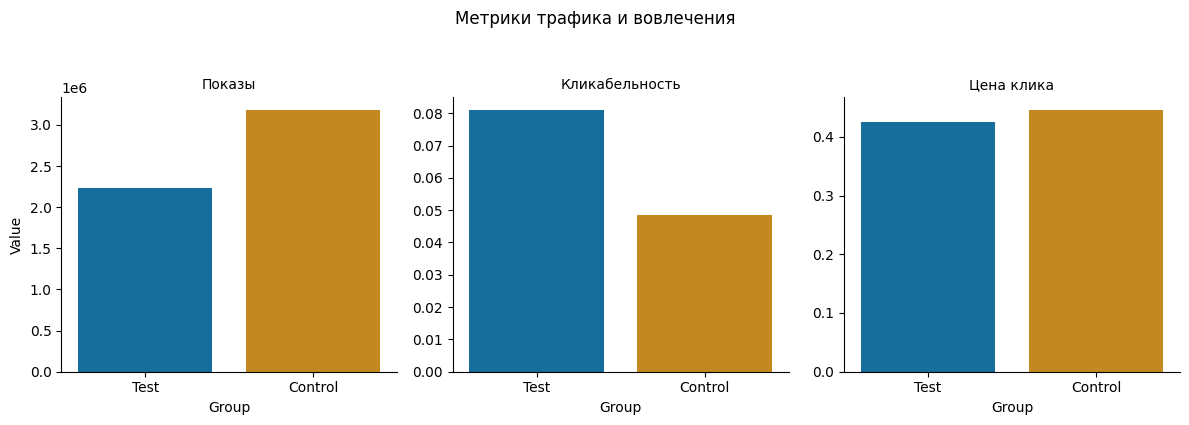

<Figure size 1200x400 with 0 Axes>

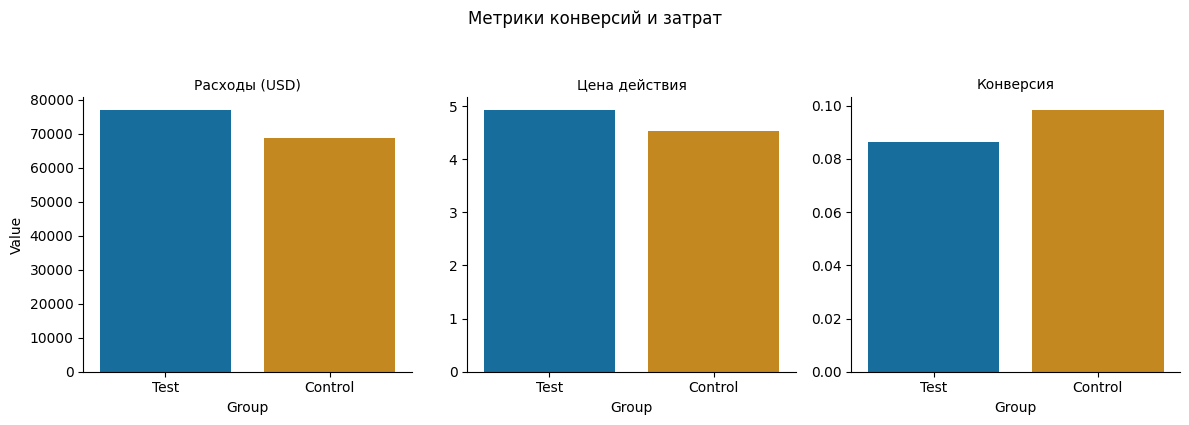

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Подготовка данных
df_metrics = pd.concat([
    pd.DataFrame(metrics_test, index=['Test']),
    pd.DataFrame(metrics_control, index=['Control'])
])
df_long = df_metrics.reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')
df_long = df_long.rename(columns={'index': 'Group'})

# Группа 1: Метрики трафика и вовлечения
group1 = ['Показы', 'Кликабельность', 'Цена клика']

# Группа 2: Метрики конверсий и затрат
group2 = ['Цена действия', 'Конверсия', 'Расходы (USD)']

# Функция для построения группы графиков
def plot_metric_group(metrics_list, title):
    plt.figure(figsize=(12, 4))
    g = sns.FacetGrid(df_long[df_long['Metric'].isin(metrics_list)],
                     col='Metric',
                     col_wrap=3,
                     height=4,
                     sharey=False)
    g.map_dataframe(sns.barplot, x='Group', y='Value', hue='Group',
                   palette='colorblind', legend=False)
    g.set_titles("{col_name}")
    g.fig.suptitle(title, y=1.05)
    plt.tight_layout()
    plt.show()

# Построение графиков
plot_metric_group(group1, 'Метрики трафика и вовлечения')
plot_metric_group(group2, 'Метрики конверсий и затрат')

In [44]:
def plot_funnel(df, funnel_steps, step_names, palette=None, title=None, figsize=(12, 7)):
    """
    Улучшенная функция для построения воронки конверсий:
    - Исправлены предупреждения о доступе по позициям
    - Добавлена обработка отсутствующих групп
    - Улучшено позиционирование подписей

    Параметры:
    df: DataFrame с данными
    funnel_steps: список столбцов с этапами воронки
    step_names: названия этапов для отображения
    palette: словарь цветов для групп
    title: заголовок графика
    figsize: размер графика
    """
    # Подготовка данных
    funnel_data = df.groupby('group')[funnel_steps].sum()

    # Проверка наличия обеих групп
    available_groups = funnel_data.index.tolist()
    if 'test' not in available_groups or 'control' not in available_groups:
        raise ValueError("DataFrame должен содержать обе группы: 'test' и 'control'")

    max_value = funnel_data.max().max()

    # Настройки по умолчанию
    if palette is None:
        palette = {'test': '#006BA4', 'control': '#FF800E'}
    if title is None:
        title = 'Воронка конверсий: абсолютные значения с конверсией между шагами'

    # Создание фигуры
    plt.figure(figsize=figsize)
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    # Основные линии для каждой группы
    for group in ['test', 'control']:
        group_values = funnel_data.loc[group].values
        plt.plot(step_names, group_values,
                 color=palette[group],
                 linewidth=2,
                 marker='o',
                 markersize=8,
                 label=f'{group.capitalize()} группа (n={len(df[df["group"]==group])})')

    # Подписи конверсии между шагами
    for i in range(1, len(step_names)):
        for group in ['test', 'control']:
            # Используем .iloc для доступа по позициям
            prev_val = funnel_data.loc[group].iloc[i-1]
            curr_val = funnel_data.loc[group].iloc[i]
            conv_rate = curr_val / prev_val * 100

            # Автоматическое позиционирование подписей
            x_pos = i - 0.5
            y_pos = (prev_val + curr_val) / 2
            y_offset = -0.12 * max_value if group == 'test' else 0.12 * max_value

            plt.text(x_pos, y_pos + y_offset,
                    f'{conv_rate:.1f}%',
                    fontsize=10,
                    color=palette[group],
                    ha='center',
                    va='center',
                    bbox=dict(facecolor='white',
                             edgecolor=palette[group],
                             boxstyle='round,pad=0.3',
                             alpha=0.8))

    # Настройки оформления
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel('Шаг воронки', fontsize=12)
    plt.ylabel('Количество действий', fontsize=12)
    plt.legend(loc='upper right', fontsize=10)
    plt.ylim(0, max_value * 1.35)

    # Добавляем общую конверсию в заголовок
    for group in ['test', 'control']:
        total_conv = funnel_data.loc[group].iloc[-1] / funnel_data.loc[group].iloc[0] * 100
        plt.text(0.02, 0.95 - (0.05 * (1 if group == 'test' else 2)),
                f'Общая конверсия ({group}): {total_conv:.1f}%',
                transform=plt.gca().transAxes,
                color=palette[group],
                fontsize=10)

    plt.tight_layout()
    plt.show()

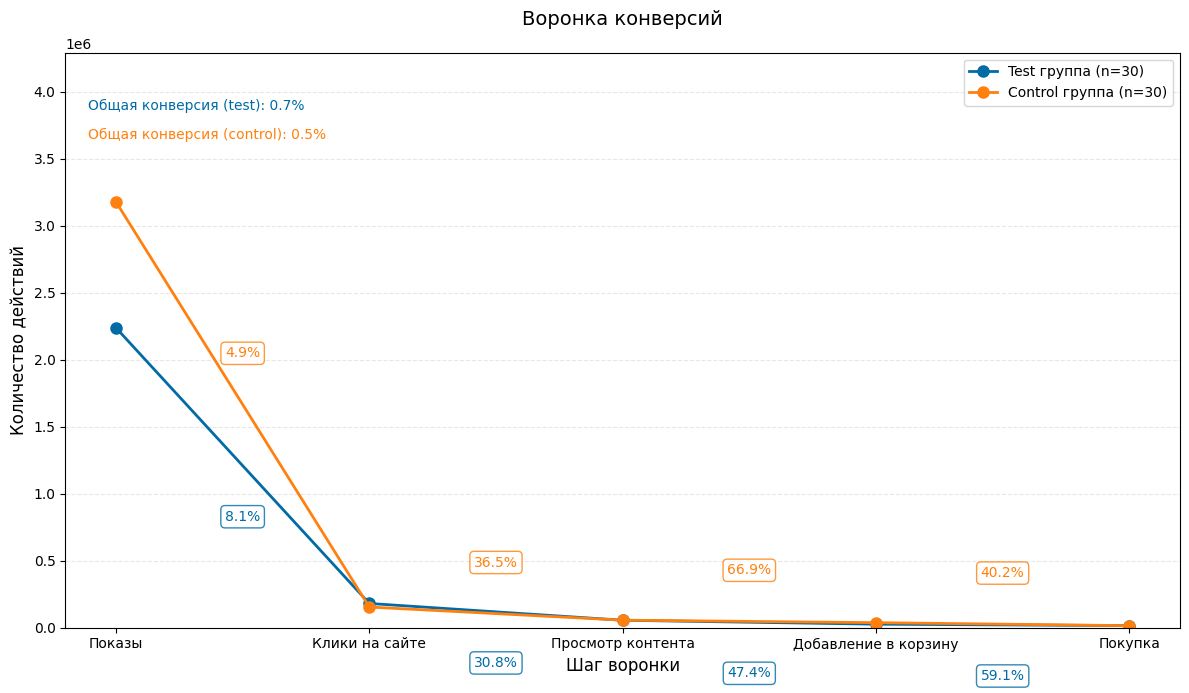

In [45]:
# Построение графика
funnel_steps = ['impressions', 'website_clicks', 'view_content', 'add_to_cart', 'purchase']
step_names = ['Показы','Клики на сайте', 'Просмотр контента', 'Добавление в корзину', 'Покупка']
palette = {'test': '#006BA4', 'control': '#FF800E'}

plot_funnel(
    df=pd.concat([df_test, df_control]),
    funnel_steps=funnel_steps,
    step_names=step_names,
    palette=palette,
    title='Воронка конверсий',
    figsize=(12, 7)
)

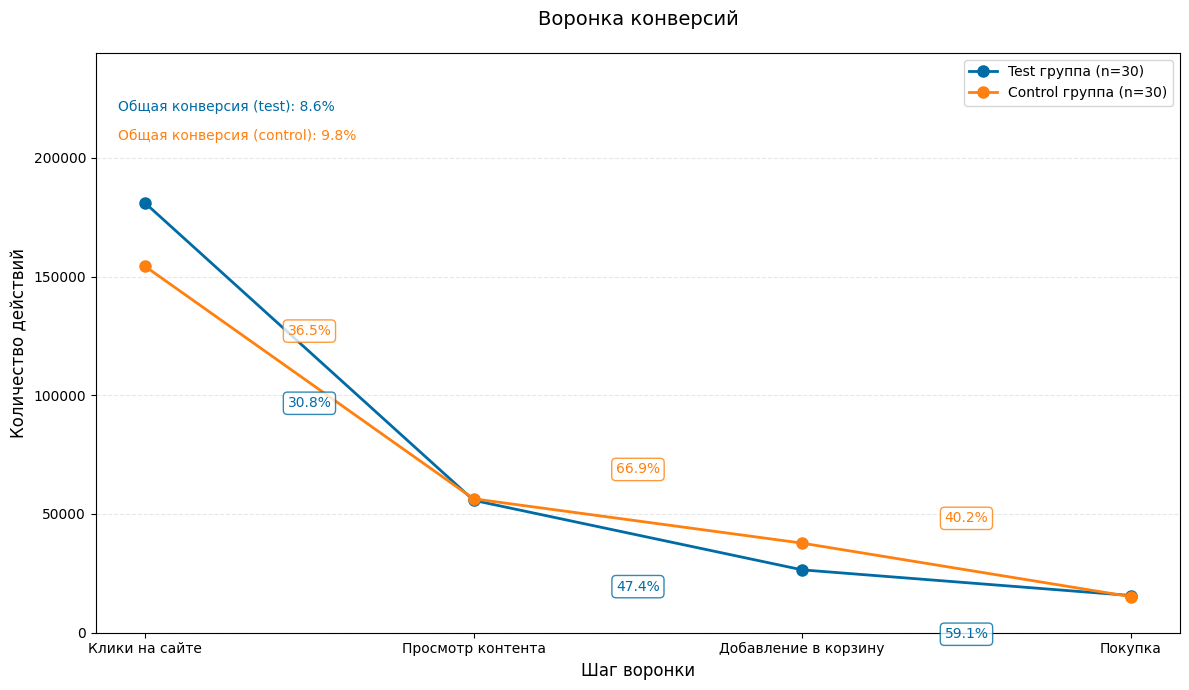

In [41]:
# Построение графика
funnel_steps = ['website_clicks', 'view_content', 'add_to_cart', 'purchase']
step_names = ['Клики на сайте', 'Просмотр контента', 'Добавление в корзину', 'Покупка']
palette = {'test': '#006BA4', 'control': '#FF800E'}

plot_funnel(
    df=pd.concat([df_test, df_control]),
    funnel_steps=funnel_steps,
    step_names=step_names,
    palette=palette,
    title='Воронка конверсий',
    figsize=(12, 7)
)

In [46]:
from statsmodels.stats.proportion import proportions_ztest

# Количество покупок и кликов для каждой группы
count = [df_control['purchase'].sum(), df_test['purchase'].sum()]
nobs = [df_control['website_clicks'].sum(), df_test['website_clicks'].sum()]

# Z-тест для пропорций
z_stat, p_value = proportions_ztest(count, nobs)
print(f"Z-статистика: {z_stat:.4f}, p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Различия статистически значимы (отвергаем нулевую гипотезу)")
else:
    print("Различия не статистически значимы (не отвергаем нулевую гипотезу)")

Z-статистика: 11.8387, p-value: 0.0000
Различия статистически значимы (отвергаем нулевую гипотезу)


In [47]:
from statsmodels.stats.power import TTestIndPower
import numpy as np

# Расчет параметров
mean_test = df_test['purchase'].mean()
mean_control = df_control['purchase'].mean()
std = df_test['purchase'].std()
n = len(df_test)

# Размер эффекта (Cohen's d)
effect_size = (mean_test - mean_control) / std
print(f"Размер эффекта: {effect_size:.3f}")

Размер эффекта: -0.007


In [48]:
# Рассчитайте разницу в конверсии
conv_test = df_test['purchase'].sum() / df_test['website_clicks'].sum()
conv_control = df_control['purchase'].sum() / df_control['website_clicks'].sum()
effect_size = conv_test - conv_control
print(f"Разница в конверсии: {effect_size:.4f} или {effect_size*100:.2f}%")

Разница в конверсии: -0.0118 или -1.18%


In [49]:
from statsmodels.stats.power import zt_ind_solve_power
import statsmodels.stats.proportion as prop

# Параметры для power analysis
nobs = len(df_test)  # Размер одной группы
alpha = 0.05  # Уровень значимости
effect_size_prop = prop.proportion_effectsize(conv_control, conv_test)  # Размер эффекта для пропорций

# Расчет мощности
power = zt_ind_solve_power(
    effect_size=effect_size_prop,
    nobs1=nobs,
    alpha=alpha,
    ratio=1.0
)
print(f"Мощность теста: {power:.3f}")
print(effect_size_prop)

Мощность теста: 0.053
0.04094723297111014


In [50]:
def check_sample_size(df_control, df_test, conv_control, conv_test, power=0.8, alpha=0.05):
    from statsmodels.stats.power import zt_ind_solve_power
    import statsmodels.stats.proportion as prop

    # Текущие размеры
    n_control = len(df_control)
    n_test = len(df_test)

    # Расчет требуемого размера
    effect_size = prop.proportion_effectsize(conv_control, conv_test)
    required_n = zt_ind_solve_power(effect_size=effect_size, power=power, alpha=alpha, ratio=1.0)

    # Вывод результатов
    print(f"ТЕКУЩИЙ РАЗМЕР ВЫБОРКИ:")
    print(f"Контроль: {n_control} | Тест: {n_test} | Всего: {n_control + n_test}")
    print(f"\nТРЕБУЕМЫЙ РАЗМЕР ДЛЯ power={power*100}%:")
    print(f"На группу: {round(required_n)} | Всего: {round(required_n)*2}")

    if min(n_control, n_test) >= required_n:
        print("\n✅ Выборка ДОСТАТОЧНА для обнаружения эффекта")
    else:
        print("\n❌ Выборка НЕДОСТАТОЧНА. Необходимо добавить:")
        print(f"- Контроль: +{max(0, round(required_n - n_control))}")
        print(f"- Тест: +{max(0, round(required_n - n_test))}")

# Пример использования
check_sample_size(
    df_control=df_control,
    df_test=df_test,
    conv_control=0.10,  # Текущая конверсия контроля
    conv_test=0.12      # Ожидаемая конверсия теста
)

ТЕКУЩИЙ РАЗМЕР ВЫБОРКИ:
Контроль: 30 | Тест: 30 | Всего: 60

ТРЕБУЕМЫЙ РАЗМЕР ДЛЯ power=80.0%:
На группу: 3835 | Всего: 7670

❌ Выборка НЕДОСТАТОЧНА. Необходимо добавить:
- Контроль: +3805
- Тест: +3805


Вывод:
  тест показал статистически значимое снижение конверсии на 1.18% (p < 0.001), но размер эффекта крайне мал (h = -0.007). С мощностью 5.3% и недостаточной выборкой (30 vs требуемые 3,835 на группу) результаты ненадежны. Рекомендуется перезапустить тест с достаточным объемом данных или пересмотреть гипотезу, если эффект не имеет практической ценности.